In [1]:
import sys
from pathlib import Path
# clear argv to avoid argparse reading Jupyter's -f
sys.argv = ['']
%matplotlib inline
# Ensure src/ directory is on sys.path
current_dir = Path().resolve()
project_root = current_dir.parent
print(f"Project root: {project_root}")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.grid_world import GridWorld
import random
import numpy as np

Project root: /Volumes/macmini-m2-outer/LocalPro/Computition/GridWorldTraining


In [2]:
def init_tables(row, col, forbidden_states, target_state):
    '''
    action 1~5: down, right, up, left, stay
    '''
    q_table = np.zeros((row * col, 5))
    print("forbidden states:", forbidden_states)

    policy_matrix = np.zeros((row * col, 5))
    values = np.zeros((row * col,))
    # if at point s, take action to a forbidden states, then q(s,a) = -1
    # besides, at the edge of the grid, taking action to go outside the grid, q(s,a) = -1
    for s in range(row * col):
        state_row = s // col
        state_col = s % col

        for a in range(5):
            if a == 0:  # down
                next_state = (state_col, state_row + 1)
            elif a == 1:  # right
                next_state = (state_col + 1, state_row)
            elif a == 2:  # up
                next_state = (state_col, state_row - 1)
            elif a == 3:  # left
                next_state = (state_col - 1, state_row)
            else:  # stay
                next_state = (state_col, state_row)
            # check if next_state is out of bounds
            if (next_state[0] < 0 or next_state[0] >= row or
                next_state[1] < 0 or next_state[1] >= col or
                next_state in forbidden_states):
                q_table[s, a] = -1

            # if next_state is target state, we can also set q(s,a) = 1 to indicate terminal state
            if next_state == target_state:
                q_table[s, a] = 1
            elif next_state in forbidden_states:
                q_table[s, a] = -1
        # if at s, take a to the target state, then q(s,a) = -1
        policy_matrix[s, np.argmax(q_table[s])] = 1
        values[s] = np.max(q_table[s])

    return q_table, policy_matrix, values


In [3]:
env = GridWorld()
state = env.reset()    
forbidden_states = env.forbidden_states
target_state = env.target_state
q_table, policy_matrix, values = init_tables(env.env_size[0], env.env_size[1], forbidden_states, target_state)
# Discount factor for future rewards
gamma = 0.9


forbidden states: [(2, 1), (3, 3), (1, 3)]


In [4]:

# value iteration update
for _ in range(100):
    for s in range(env.num_states):
        state_row = s // env.env_size[1]
        state_col = s % env.env_size[1]
        state = (state_col, state_row)
        if state == target_state or state in forbidden_states:
            continue
        q_values = []
        for a in range(len(env.action_space)):
            action = env.action_space[a]
            next_state, reward = env._get_next_state_and_reward(state, action)
            next_state_index = next_state[1] * env.env_size[1] + next_state[0]
            q_value = reward + gamma * np.max(q_table[next_state_index])
            q_values.append(q_value)
        q_table[s] = q_values
        policy_matrix[s] = 0
        policy_matrix[s, np.argmax(q_table[s])] = 1
        values[s] = np.max(q_table[s])

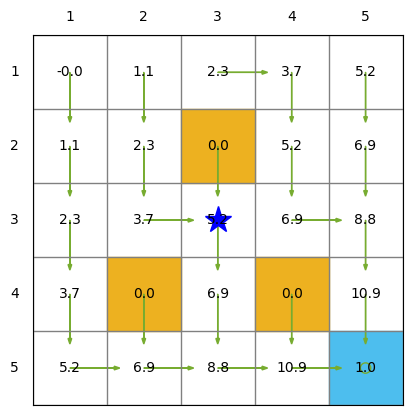

Step: 0, Action: (0, 1), State: [3 4], Reward: -1, Done: False


<Figure size 640x480 with 0 Axes>

Step: 1, Action: (0, 1), State: [3 5], Reward: -1, Done: False


<Figure size 640x480 with 0 Axes>

Step: 2, Action: (1, 0), State: [4 5], Reward: -1, Done: False


<Figure size 640x480 with 0 Axes>

Step: 3, Action: (1, 0), State: [5 5], Reward: 10, Done: True


In [6]:

env.add_policy(policy_matrix, True)
env.add_state_values(values, is_ipynb = True)
for t in range(10):
    env.render(is_ipynb=True)

    # get current state
    s = env.agent_state[1] * env.env_size[1] + env.agent_state[0]
    action = env.action_space[np.argmax(policy_matrix[s])]
    next_state, reward, done, info = env.step(action)
    print(f"Step: {t}, Action: {action}, State: {next_state+(np.array([1,1]))}, Reward: {reward}, Done: {done}")
    if done:
        break

